In [1]:
## 함수, 라이브러리 불러오기
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
import joblib

In [2]:
# train 샘플
df = pd.read_csv("X_train_0404.csv", encoding='cp949')
# test 샘플
dfT = pd.read_csv("X_test_0404.csv",encoding='cp949')

In [3]:
##   [0:'custid' 1:'date_time' 2:'store' 3:'product' 4:'brand' 5:'corner' 6:'pc' 7:'part'
##   8:'imported' 9:'amount' 10:'discount' 11:'installment']
# train data 전처리
custid = tuple([int(x) for x in df['custid']])
mthArray = tuple([int(x.split('-')[1]) for x in df['date_time']])
stores = tuple([x for x in df['store']])
brands = tuple([x for x in df['brand']])
corners = tuple([x for x in df['corner']])
pc = tuple([x for x in df['pc']])
parts = tuple([x for x in df['part']])
originalPrice = tuple([int(x) for x in df['amount']])
offPrice = tuple([int(x) for x in df['discount']])
priceList = tuple(np.subtract(originalPrice, offPrice))
# 환불은 priceList가 음수인 경우에 환불로 인식, discount는 discount가 0이 아닐 경우에
# discount로 인식
refund = tuple([int(x < 0) for x in priceList])
discount = tuple([int(x != 0) for x in offPrice])
# OHE 를 사용하지 않고 dict를 이용해서 정수로 encoding 했습니다.
storeID = list(set(stores))
storeID.sort()
brandID = list(set(brands))
brandID.sort()
cornerID = list(set(corners))
cornerID.sort()
pcID = list(set(pc))
pcID.sort()
partID = list(set(parts))
partID.sort()
dictBrand = dict(zip(brandID, np.array(range(len(brandID)))))
dictStore = dict(zip(storeID, np.array(range(len(storeID)))))
dictCorner = dict(zip(cornerID, np.array(range(len(cornerID)))))
dictPC = dict(zip(pcID, np.array(range(len(pcID)))))
dictPart = dict(zip(partID, np.array(range(len(partID)))))

brandIDList = tuple([int(dictBrand[x]) for x in brands])
storeIDList = tuple([int(dictStore[x]) for x in stores])
cornerIDList = tuple([int(dictCorner[x]) for x in corners])
pcIDList = tuple([int(dictPC[x]) for x in pc])
partIDList = tuple([int(dictPart[x]) for x in partID])

# 필요 데이터 X_train: custid, storeIDList, brandIDList, originalPrice, discount
# y_train: refund
short = np.array([(a,b,c,d,e,f,g,h,i) for (a,b,c,d,e,f,g,h,i) in zip(custid, storeIDList, brandIDList, cornerIDList, pcIDList, partIDList, originalPrice, discount, refund)])

del df

In [4]:
##   [0:'custid' 1:'date_time' 2:'store' 3:'product' 4:'brand' 5:'corner' 6:'pc' 7:'part'
##   8:'imported' 9:'amount' 10:'discount' 11:'installment']
# test data 전처리
# data cleansing -> train data에 없는 값은 지웁니다.
dfT = np.array(dfT)
dfT = [x for x in dfT if x[4] in brandID and x[5] in cornerID and x[6] in pcID and x[7] in partID]
dfT = np.transpose(dfT)
custidT = tuple([int(x) for x in dfT[0]])
mthArrayT = tuple([int(x.split('-')[1]) for x in dfT[1]])
storesT = tuple([x for x in dfT[2]])
brandsT = tuple([x for x in dfT[4]])
cornersT = tuple([x for x in dfT[5]])
pcT = tuple([x for x in dfT[6]])
partsT = tuple([x for x in dfT[7]])
originalPriceT = tuple([int(x) for x in dfT[9]])
offPriceT = tuple([int(x) for x in dfT[10]])
priceListT = tuple(np.subtract(originalPriceT, offPriceT))
refundT = tuple([int(x < 0) for x in priceListT])
discountT = tuple([int(x != 0) for x in offPriceT])
brandIDListT = tuple([int(dictBrand[x]) for x in brandsT])
storeIDListT = tuple([int(dictStore[x]) for x in storesT])
cornerIDListT = tuple([int(dictCorner[x]) for x in cornersT])
pcIDListT = tuple([int(dictPC[x]) for x in pcT])
partIDListT = tuple([int(dictPart[x]) for x in partsT])

shortT = np.array([custidT, storeIDListT, brandIDListT, cornerIDListT, pcIDListT, partIDListT, originalPriceT, discountT, refundT])
shortT = np.transpose(shortT)

In [5]:
# 뒤에 있는 코드에 적용하기 위해서 dataSet들을 copy 한다.
dataSet = np.copy(short)
trainSet = np.copy(shortT)

del short, shortT, dfT

In [6]:
# X_test, y_test, X_train, y_train 값들을 정리한다.
dataSet = np.array(dataSet)

df = pd.DataFrame(dataSet,columns=['custid','storeID','brandID', 'cornerID', 'pcIDList', 'partIDList', 'oPrice','discount', 'refund'])
del dataSet

X_train = df[['custid','storeID','brandID', 'cornerID', 'pcIDList', 'partIDList', 'oPrice','discount']]
y_train = df['refund']
del df

trainSet = np.array(trainSet)

dfT = pd.DataFrame(trainSet,columns=['custid','storeID','brandID', 'cornerID', 'pcIDList', 'partIDList', 'oPrice','discount', 'refund'])
del trainSet

X_test = dfT[['custid','storeID','brandID', 'cornerID', 'pcIDList', 'partIDList', 'oPrice','discount']]
y_test = dfT['refund']
del dfT

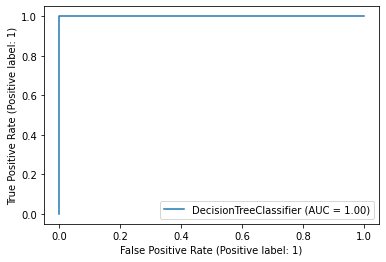

In [7]:
# Decision Tree 모델

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
tree = accuracy_score(y_test, predictions)
# 모델 파일을 저장한다.
filename = 'decisionTree.sav'
joblib.dump(model, filename)

# 시각화
disp = plot_roc_curve(model, X_test, y_test)
plt.show()

del model, filename

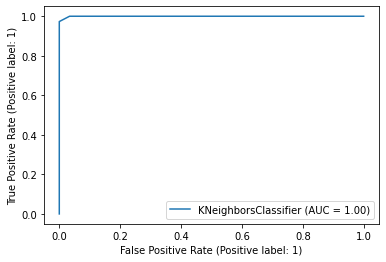

In [8]:
# k-NN 모델

model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)
knn = accuracy_score(y_test, predictions2)
# 모델 파일을 저장한다.
filename = 'kNN.sav'
joblib.dump(model2, filename)

# 시각화
disp = plot_roc_curve(model2, X_test, y_test)
plt.show()

del model2, filename

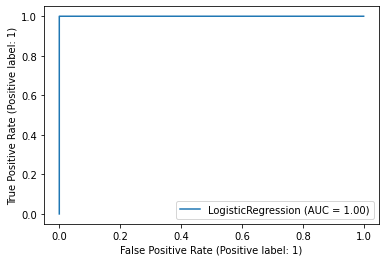

In [9]:
# Logistic Regression 모델

model3 = LogisticRegression()
model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)
logReg = accuracy_score(y_test, predictions3)
# 모델 파일을 저장한다.
filename = 'LogisticRegression.sav'
joblib.dump(model3, filename)

# 시각화
disp = plot_roc_curve(model3, X_test, y_test)
plt.show()

del model3, filename

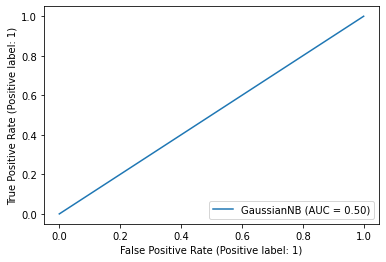

In [10]:
# Gaussian NB 모델

model4 = GaussianNB()
model4.fit(X_train, y_train)
predictions4 = model4.predict(X_test)
gNB = accuracy_score(y_test, predictions4)
# 모델 파일을 저장한다.
filename = 'GaussianNB.sav'
joblib.dump(model4, filename)

# 시각화
disp = plot_roc_curve(model4, X_test, y_test)
plt.show()

del model4, filename

In [11]:
# 모델 정확도 비교

print("Tree: %.9f\nKNN: %.9f\nLogistic Regression: %.9f\nGaussian NB: %.9f" % (tree, knn, logReg, gNB))

Tree: 1.000000000
KNN: 0.932242682
Logistic Regression: 1.000000000
Gaussian NB: 0.932242682
